In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#pip install --upgrade peft

In [3]:
# Load peft config for pre-trained checkpoint etc.
#peft_model_id = "results"
config = PeftConfig.from_pretrained("M2_LR_S2_EXT3_EXP9_model")

# load base LLM model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, "M2_LR_S2_EXT3_EXP9_model", use_dora = False, device_map={"":0})
model.eval()

print("Peft model loaded")

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Peft model loaded


In [4]:
from datasets import load_from_disk, DatasetDict
from random import randrange


# Load dataset from the hub and get a sample
#dataset = load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank')
dataset = DatasetDict({
    'train': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/train'),
    'validation': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/validation'),
    'test': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/test')
})
sample = dataset['test'][randrange(len(dataset["test"])-300)]


In [5]:
input_ids = tokenizer(sample["description"], return_tensors="pt", truncation=True).input_ids.cpu()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.9)
print(f"input sentence: {sample['description']}\n{'---'* 20}")

print(f"summary:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]}")

input sentence: no . 4 a . 4 a , 4 b and 5 , a more aggressive carding results with an increased proportion in lightweight fiber waste g. conversely , in case the carding clearance is enlarged ( such a position is illustrated in fig . 3 a . background of the invention [ 0003 ] this invention relates to a device and method for detecting lightweight waste such as short fibers , dust , fiber fragments , fly and the like in a carding machine . 4 b ) , a less aggressive , gentle carding results with a smaller proportion of lightweight fiber waste g. as illustrated in fig . [ 0027 ] in the description which follows , short fiber content , dust and fiber fragments , that is , lightweight fiber waste , are hereafter collectively designated as ksf . [ 0004 ] in a known apparatus , such as disclosed , for example , in german patent no . [ 0024 ] turning to fig . 5,918,349 . 4 a , 4 b and 5 . 4 a and 4 b ) , the slide guide 30 has an outer surface which , when viewed circumferentially , is throug

In [6]:
outputs

tensor([[    2,     0,   250,  1886,   154,  3563,    16,  8895,    19,    10,
           797,     8, 24555,  2187,    13, 18624,     5,  1886,   154, 11855,
             4,   520,    10,  1886,   154,   609,    16,   278,    30,     5,
          9562,  2343,    11, 29959,    29,   479,     5, 18624,  2187,     9,
         29959,    29,     4,   231,   924,    10,  1803, 41071,     9,    41,
          5175,   797,   467,    61,    34,    10,   797,  2187,     6,  3665,
             7,    41,  8135,  2577,  2187,     6,    10,  2332,  2187,   843,
          2156,    10,  5405,  1718,    13,     5,  4243,  2491,     8,     5,
         25406,  1164, 14978,  2187,  2843,   479,     2]])

In [7]:
import evaluate
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm

# Metric
metric = evaluate.load("rouge")

def evaluate_peft_model(sample,max_target_length=512):
    # generate summary
    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cpu(), do_sample=True, top_p=0.9, max_new_tokens=max_target_length)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)
    # decode eval sample
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(sample['labels'] != -100, sample['labels'], tokenizer.pad_token_id)
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# load test dataset from distk
test_dataset = load_from_disk("./tokenized_data_S2_EXT3/test").with_format("torch")

# run predictions
# this can take ~45 minutes
predictions, references = [] , []
for sample in tqdm(test_dataset):
    p,l = evaluate_peft_model(sample)
    predictions.append(p)
    references.append(l)

# compute metric
rogue = metric.compute(predictions=predictions, references=references, use_stemmer=True)

# print results
print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

# Rogue1: 50.386161%
# rouge2: 24.842412%
# rougeL: 41.370130%
# rougeLsum: 41.394230%

100%|██████████| 2259/2259 [12:14:25<00:00, 19.51s/it]    


Rogue1: 35.411043%
rouge2: 13.716825%
rougeL: 23.779670%
rougeLsum: 23.876581%


In [9]:
# Extracting Rouge scores
rouge1_score = rogue['rouge1'] * 100
rouge2_score = rogue['rouge2'] * 100
rougeL_score = rogue['rougeL'] * 100
rougeLsum_score = rogue['rougeLsum'] * 100

# Plotting the Rouge scores
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Rouge-Lsum']
scores = [rouge1_score, rouge2_score, rougeL_score, rougeLsum_score]

(0.0, 100.0)

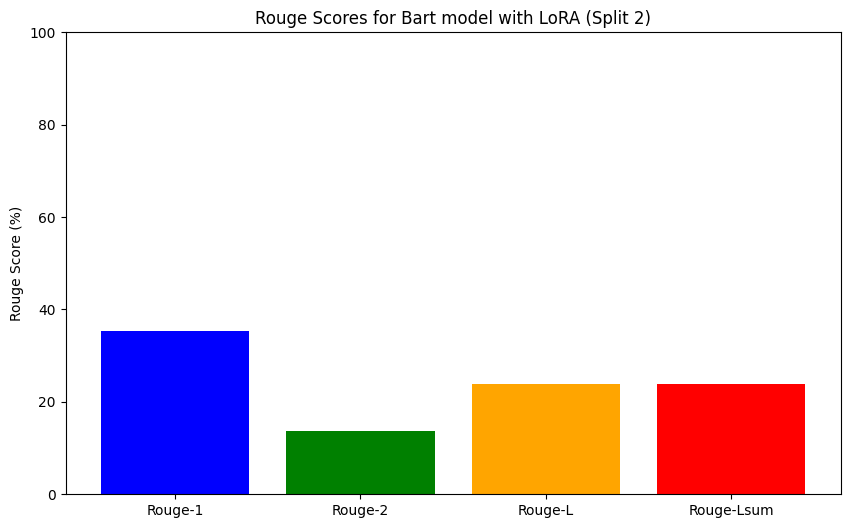

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Rouge Score (%)')
plt.title('Rouge Scores for Bart model with LoRA (Split 2)')
plt.ylim(0, 100)